In [1]:
import pandas as pd
import numpy as np
import graphviz
from treelib import Node, Tree

In [2]:
train_data_m = pd.read_csv("PlayTennis.csv") 
train_data_m.head() 

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


```
Total row = 14
Row with "Yes" class = 9
Row with "No" class = 5
Complete entropy of dataset is -
H(S) = - p(Yes) * log2(p(Yes)) - p(No) * log2(p(No))
     = - (9/14) * log2(9/14) - (5/14) * log2(5/14)
     = - (-0.41) - (-0.53)
     = 0.94

In [3]:
def calc_total_entropy(train_data, label, class_list):
    total_row = train_data.shape[0] #the total size of the dataset
    total_entr = 0
    
    for c in class_list: #for each class in the label
        total_class_count = train_data[train_data[label] == c].shape[0] #number of the class
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row) #entropy of the class
        total_entr += total_class_entr #adding the class entropy to the total entropy of the dataset
    
    return total_entr

```
Categorical values of Outlook - Sunny, Overcast and Rain
Total count of row containing:
  Sunny = 5
  Sunny & Yes = 2
  Sunny & No = 3
>> H(Outlook=Sunny) = -(2/5)*log(2/5)-(3/5)*log(3/5) = 0.971
Total count of row containing:  
  Rain = 5
  Rain & Yes = 3
  Rain & No = 2
>> H(Outlook=Rain) = -(3/5)*log(3/5)-(2/5)*log(2/5) = 0.971
Total count of row containing:  
  Overcast = 4
  Overcast & Yes = 4
  Overcast & No = 0
>> H(Outlook=Overcast) = -(4/4)*log(4/4)-0 = 0

In [4]:
def calc_entropy(feature_value_data, label, class_list):
    class_count = feature_value_data.shape[0]
    entropy = 0
    
    for c in class_list:
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0] #row count of class c 
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count #probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy

```
I(Outlook) = p(Sunny) * H(Outlook=Sunny) + p(Rain) * H(Outlook=Rain) + p(Overcast) * H(Outlook=Overcast)
= (5/14)*0.971 + (5/14)*0.971 + (4/14)*0
= 0.693
Information Gain = H(S) - I(Outlook)
                 = 0.94 - 0.693
                 = 0.247

In [5]:
def calc_info_gain(feature_name, train_data, label, class_list):
    feature_value_list = train_data[feature_name].unique() #unqiue values of the feature
    total_row = train_data.shape[0]
    feature_info = 0.0
    
    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value] #filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = calc_entropy(feature_value_data, label, class_list) #calculcating entropy for the feature value
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy #calculating information of the feature value
        
    return calc_total_entropy(train_data, label, class_list) - feature_info #calculating information gain by subtracting

```
Information gain:
  Outlook = 0.247 (Highest value)
  Temperature = 0.0292
  Humidity = 0.153
  Wind = 0.048

In [6]:
def find_most_informative_feature(train_data, label, class_list):
    feature_list = train_data.columns.drop(label) #finding the feature names in the dataset
                                            #N.B. label is not a feature, so dropping it
    max_info_gain = -1
    max_info_feature = None
    
    for feature in feature_list:  #for each feature in the dataset
        feature_info_gain = calc_info_gain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain: #selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature
            
    return max_info_feature

In [7]:
def generate_sub_tree(feature_name, train_data, label, class_list):
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node
    
    for feature_value, count in feature_value_count_dict.items():
        feature_value_data = train_data[train_data[feature_name] == feature_value] #dataset with only feature_name = feature_value
        
        assigned_to_node = False #flag for tracking feature_value is pure class or not
        for c in class_list: #for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0] #count of class c

            if class_count == count: #count of (feature_value = count) of class (pure class)
                tree[feature_value] = c #adding node to the tree
                train_data = train_data[train_data[feature_name] != feature_value] #removing rows with feature_value
                assigned_to_node = True
        if not assigned_to_node: #not pure class
            tree[feature_value] = "?" #as feature_value is not a pure class, it should be expanded further, 
                                      #so the branch is marking with ?
            
    return tree, train_data

In [8]:
def make_tree(root, prev_feature_value, train_data, label, class_list):
    if train_data.shape[0] != 0: #if dataset becomes enpty after updating
        max_info_feature = find_most_informative_feature(train_data, label, class_list) #most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list) #getting tree node and updated dataset
        next_root = None
        
        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]
        
        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node] #using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list) #recursive call with updated dataset

In [9]:
def id3(train_data_m, label):
    train_data = train_data_m.copy() #getting a copy of the dataset
    tree = {} #tree which will be updated
    class_list = train_data[label].unique() #getting unqiue classes of the label
    make_tree(tree, None, train_data, label, class_list) #start calling recursion
    return tree

In [10]:
tree = id3(train_data_m, 'Play Tennis')

In [11]:
from pprint import pp
pp(tree)

{'Outlook': {'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}},
             'Overcast': 'Yes',
             'Rain': {'Wind': {'Weak': 'Yes', 'Strong': 'No'}}}}


In [12]:
# def create_tree(dict_tree: dict):
#     tree = Tree()
#     
#     def add_node(dict_tree: dict, ids: dict, parent_node = None):
#         for key, val in dict_tree.items():
#             if key not in ids:
#                 ids[key] = 1
#             tree.create_node(key, key + str(ids[key]), parent=parent_node)
#             ids[key] += 1
#             if type(val) == str:
#                 if val not in ids:
#                     ids[val] = 1
#                 tree.create_node(val, val + str(ids[val]), parent=key + str(ids[key] - 1))
#                 ids[val] += 1
#             elif type(val) == dict:
#                 add_node(dict_tree=val, ids=ids, parent_node=key + str(ids[key] - 1))
#                 
#     add_node(dict_tree, {})
#     return tree

In [178]:
def create_tree(dict_tree: dict, columns: set):
    tree = graphviz.Digraph('tree', engine="neato")  # ['circo', 'dot', 'fdp', 'neato', 'osage', 'patchwork', 'sfdp', 'twopi']
    tree.attr(rankdir='LR', size='20,20')
    tree.attr('node', shape='rectangle')
    
    def add_node(dict_tree: dict, ids: dict, parent_node = None):
        for key, val in dict_tree.items():
            if key not in ids:
                ids[key] = 1
            tree.node(key + str(ids[key]), key, shape="ellipse" if key in columns else None)
            tree.edge(parent_node, key + str(ids[key]), constraint='false')
            ids[key] += 1
            if type(val) == str:
                if val not in ids:
                    ids[val] = 1
                tree.node(val + str(ids[val]), val, shape="egg")
                tree.edge(key + str(ids[key] - 1), val + str(ids[val]))
                ids[val] += 1
            elif type(val) == dict:
                add_node(dict_tree=val, ids=ids, parent_node=key + str(ids[key] - 1))
                
    ids = {}
    for key, val in dict_tree.items():
        ids[key] = 1
        tree.node(key + str(ids[key] - 1), key, shape="ellipse" if key in columns else None)
        add_node(val, ids, key + str(ids[key] - 1))
    return tree

In [179]:
tree_view = create_tree(tree, columns=set(list(train_data_m.columns)))

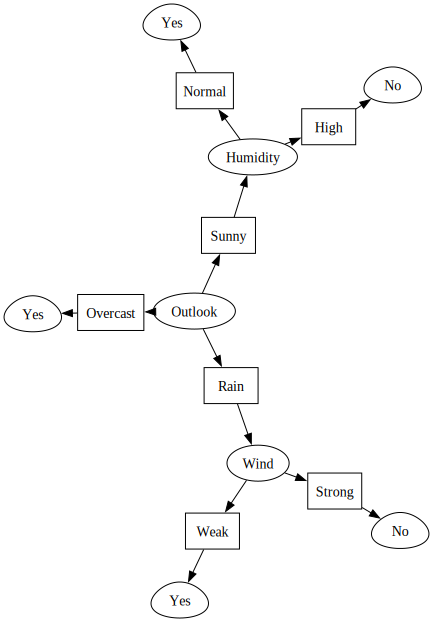

In [180]:
tree_view

In [136]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

In [106]:
def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data_m.iterrows(): #for each row in the dataset
        result = predict(tree, test_data_m.iloc[index]) #predict the row
        if result == test_data_m[label].iloc[index]: #predicted value and expected value is same or not
            correct_preditct += 1 #increase correct count
        else:
            wrong_preditct += 1 #increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct) #calculating accuracy
    return accuracy

In [18]:
test_data_m = pd.read_csv("PlayTennis.csv") #importing test dataset into dataframe

accuracy = evaluate(tree, test_data_m, 'Play Tennis') #evaluating the test dataset

In [19]:
accuracy

1.0